In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
cell_lines_lrnRNA = pd.read_excel("data/aah7111-TableS1.xlsx")
cell_lines_lrnRNA = cell_lines_lrnRNA.rename(columns={'Gene ID': 'Gene_ID'})

crispiri = pd.read_excel("data/aah7111-Table.xlsx")
crispiri = crispiri.rename(columns={'gene': 'Gene_ID'})

/home/koval/.local/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [44]:
cell_lines_lrnRNA.count()

Gene_ID                 17734
TSS ID                  17734
Transcript ID           17734
gene name               17734
chromosome              17734
strand                  17734
TSS source              17734
primary TSS 5prime      17734
primary TSS 3prime      17734
secondary TSS 5prime    17734
secondary TSS 3prime    17734
dtype: int64

In [45]:
crispiri.count()

Gene_ID                                                      5615
Mann-Whitney p-value                                         5615
hek_av                                                       5615
sgRNAs passing filter                                        5615
screen score                                                 5615
hek_RNA                                                      5615
closest protein-coding gene                                  5540
distance to closest protein-coding gene TSS (bp)             5540
closest protein-coding gene K562 growth phenotype (gamma)    5427
closest protein-coding gene expression in HEK293T (FPKM)     5489
lnc_metric                                                   5615
k562_av                                                      5615
k562_RNA                                                     5615
mcf7_av                                                      5615
mcf7_RNA                                                     5615
231_av    

In [46]:
merged = crispiri.merge(cell_lines_lrnRNA, on=['Gene_ID'])

In [47]:
merged.count()

Gene_ID                                                      5991
Mann-Whitney p-value                                         5991
hek_av                                                       5991
sgRNAs passing filter                                        5991
screen score                                                 5991
hek_RNA                                                      5991
closest protein-coding gene                                  5831
distance to closest protein-coding gene TSS (bp)             5831
closest protein-coding gene K562 growth phenotype (gamma)    5712
closest protein-coding gene expression in HEK293T (FPKM)     5777
lnc_metric                                                   5991
k562_av                                                      5991
k562_RNA                                                     5991
mcf7_av                                                      5991
mcf7_RNA                                                     5991
231_av    

### Отбираем признаки, по которым будем считать среднее значение и медианну

In [49]:
features = ['hek_av','hek_RNA', 'k562_av','k562_RNA','mcf7_av', 'mcf7_RNA','231_av', '231_RNA', 'hela_av','hela_RNA','u87_av','u87_RNA']
merged = merged.replace(np.nan, int(0))
# в данных 1 значение строка, вместо float
merged['mcf7_RNA'].loc[0] = 207951.22

/tmp/ipykernel_92633/2517393010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['mcf7_RNA'].loc[0] = 207951.22


### Легенда - lrnRNA, берем каждый  признак и сравниваем со средним и медианным значением, считаем, что если значение меньше и среднего и медианного, то такой признак дает 0-ой вклад в кодирующий потенциал, иначе вклад есть(1).



In [50]:
for feature in features:
    a = (merged[feature].abs() < merged[feature].abs().median()).to_frame()
    b = (merged[feature].abs() < merged[feature].abs().mean()).to_frame()
    choose_data = []
    for i in range(len(a)):
        if not a[feature].loc[i] or not b[feature].loc[i]:
            choose_data.append(False)
        else:
            choose_data.append(True)
    merged['score_'+feature] = choose_data
    merged['score_'+feature].astype(int)

In [51]:
merged.replace({False: 0, True: 1}, inplace=True)

### Считаем суммарный вклад признаков.( +1, если вклад есть, +0, если вклада нет)

In [52]:
merged['score_final'] = 0
for i in range(len(merged)):
    value = 0
    for feature in features:
        value+= merged.iloc[i]['score_'+feature]
    merged.loc[i,'score_final'] = value

# Распределение

<AxesSubplot:ylabel='Frequency'>

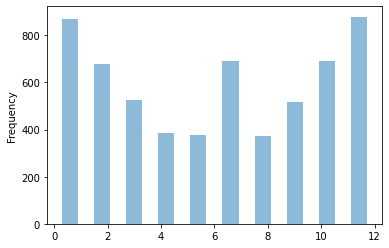

In [53]:
merged['score_final'].plot(kind='hist', alpha=0.5, rwidth=0.5)

### Проводим отбор lrnRNA, с вероятным 0-ым кодирующим потенциалом.(Легенда - всего 12 признаков, <=6 наш критерий)

In [54]:
merged['final_final_score'] = 0
for i in range(len(merged)):
    if merged.iloc[i]['score_final'] <=6:
        merged.loc[i,'final_final_score'] = 0
    else:
        merged.loc[i,'final_final_score'] = 1

### Распределнием кодирующих и некодирующих.

<AxesSubplot:ylabel='Frequency'>

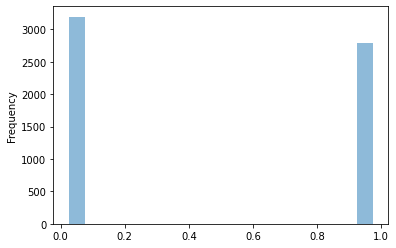

In [55]:
merged['final_final_score'].plot(kind='hist', alpha=0.5, rwidth=0.5)

In [56]:
merged.to_csv("data/merged_data.csv")
merged_score_o = merged[merged.final_final_score == 0]
merged_score_o.to_csv("data/score_0.csv")

## Потенциально некодирующие lrnRNA

In [59]:
bad_boys = pd.read_csv("data/score_0.csv")

In [60]:
bad_boys.count()

Unnamed: 0                                                   3195
Gene_ID                                                      3195
Mann-Whitney p-value                                         3195
hek_av                                                       3195
sgRNAs passing filter                                        3195
screen score                                                 3195
hek_RNA                                                      3195
closest protein-coding gene                                  3195
distance to closest protein-coding gene TSS (bp)             3195
closest protein-coding gene K562 growth phenotype (gamma)    3195
closest protein-coding gene expression in HEK293T (FPKM)     3195
lnc_metric                                                   3195
k562_av                                                      3195
k562_RNA                                                     3195
mcf7_av                                                      3195
mcf7_RNA  